In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ChessCNN(nn.Module):
    def __init__(self, input_channels=12):
        super(ChessCNN, self).__init__()

        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Fully connected layers after the convolutional layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)

        # Output layer: the number of legal moves (64 squares)
        self.fc2 = nn.Linear(512 + 64, 64)  # Concatenate CNN features with available moves


    def forward(self, x, available_moves):
        # Process the board state through the convolutional layers
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))

        # Flatten the tensor after convolutional layers
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 256 * 8 * 8)

        # Pass through the first fully connected layer
        x = torch.relu(self.fc1(x))

        # Concatenate CNN output with the available moves
        x = torch.cat((x, available_moves), dim=1)  # Concatenate along the feature dimension

        # Output layer to get logits for each move
        move_logits = self.fc2(x)

        return move_logits

In [ ]:
from torch.utils.data import Dataset

class ChessDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        position_tensor, available_moves_tensor, best_move = self.data[idx]
        return position_tensor, available_moves_tensor, best_move

In [133]:
import os 
import chess.pgn
import numpy as np
import chess.engine
# using channels 0-11, 0-5 for white, 6-11 for black
# ex: channel 0 is white pawns, channel 1 is for white knights, etc.

piece_map = {
    chess.PAWN: 0,
    chess.KNIGHT: 1,
    chess.BISHOP: 2,
    chess.ROOK: 3,
    chess.QUEEN: 4,
    chess.KING: 5
}

DATABASE_DIR = 'Lichess Elite Database'

def encode_move(move, board):
    # Initialize a vector of 130 zeros
    encoded_move = np.zeros(130, dtype=int)

    # Get the piece at the start square once
    piece = board.piece_at(move.from_square)
    if piece is None:
        return encoded_move  # If there's no piece, return empty encoding

    # Step 1: Encode the starting square (64-dimensional)
    start_square = move.from_square  # This is an integer representing the square (0-63)
    encoded_move[start_square] = 1  # Set the corresponding index to 1

    # Step 2: Encode the ending square (64-dimensional)
    end_square = move.to_square  # This is an integer representing the square (0-63)
    encoded_move[64 + end_square] = 1  # Set the corresponding index to 1 (after the first 64)

    # Step 3: Encode the piece type (1-dimensional)
    piece_type = piece.piece_type  # Get piece type (pawn=1, knight=2, etc.)
    encoded_move[128] = piece_map.get(piece_type, -1)  # Map piece type to index

    # Step 4: Encode the piece color (1-dimensional)
    piece_color = piece.color  # Get piece color (white=True, black=False)
    encoded_move[129] = 0 if piece_color == chess.WHITE else 1  # 0 for white, 1 for black

    return encoded_move

def bitboard_to_tensor(board):
    # Initialize an empty 12-channel tensor of shape (8, 8, 12)
    board_tensor = np.zeros((8, 8, 12), dtype=int)
    
    # Loop through each piece type (6 for white and 6 for black)
    for piece_type in range(1, 7):  # piece types range from 1 (pawn) to 6 (king)
        for color in [chess.WHITE, chess.BLACK]:
            piece = chess.Piece(piece_type, color)
            piece_positions = board.pieces(piece.piece_type, color)
            
            # Update the corresponding bitboard channel
            for pos in piece_positions:
                row, col = divmod(pos, 8)
                board_tensor[row, col, (color == chess.WHITE) * 6 + piece.piece_type - 1] = 1
            break
    
    return board_tensor


def load_data_to_tensors(pgn_file, engine, max_games=None):
    data = []
    with open(DATABASE_DIR + '/' + pgn_file, 'r') as pgn_file:
        count = 0
        while True:
            print(count)
            game = chess.pgn.read_game(pgn_file)
            
            if game is None or (max_games and count >= max_games):
                break

            board = game.board()
            for move in game.mainline_moves():
                position_tensor = bitboard_to_tensor(board)
                available_moves = np.zeros(64, dtype=int)

                for move in board.legal_moves:
                    available_moves[move.to_square] = 1

                best_move = get_best_move(board, engine)

                data.append((position_tensor, available_moves, best_move))
                board.push(move)
            count += 1
    return data

def get_best_move(board, engine):
    engine.set_fen_position(board.fen())
    result = engine.get_best_move()
    result = chess.Move.from_uci(result)
    return encode_move(result, board)

In [138]:
from stockfish import Stockfish
if not os.path.isdir(DATABASE_DIR):
    raise Exception(
        'Lichess Elite Database directory not found. Please download the dataset from https://database.nikonoel.fr/ and extract it to the root directory of this project.')
files = os.listdir(DATABASE_DIR)[1:]

all_data = []
engine = Stockfish(path="stockfish/stockfish-windows-x86-64-avx2.exe", parameters={"Hash": 2048, "Threads": 4})
# engine.update_engine_parameters({"Skill Level": 5})
engine.set_elo_rating(2500)
for file in files:
    data = load_data_to_tensors(files[0], engine)
    all_data.extend(data)
engine.quit()

dataset = ChessDataset(all_data)

0


KeyboardInterrupt: 

In [48]:
print(len(dataset))

46689


In [105]:
def map_move_to_class(move_pair):
    # Map a move pair (from_square, to_square) to a unique class index
    from_square, to_square = move_pair
    class_index = from_square * 64 + to_square  # 64 squares on the board
    return class_index

def train(model, dataloader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train() 
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for batch in dataloader:
            positions, moves = batch
            positions, moves = positions.to(device), moves.to(device)

            optimizer.zero_grad()
            outputs = model(positions.float())

            moves = torch.tensor([map_move_to_class(move) for move in moves], dtype=torch.long, device=device)

            loss = criterion(outputs, moves)
            loss.backward()

            optimizer.step()

            running_loss = loss.item()

            _, predicted = torch.max(outputs, 1)  # Get the predicted move
            correct_predictions += (predicted == moves).sum().item()  # Count correct predictions
            total_predictions += moves.size(0)

        avg_loss = running_loss / len(dataloader)
        accuracy = correct_predictions / total_predictions * 100

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


In [106]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
model = ChessCNN().to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


train(model, dataloader, criterion, optimizer, 10)

TypeError: ChessCNN.forward() missing 1 required positional argument: 'available_moves'

In [29]:
import chess

def test(model, board, device):
    # Convert the chess board to a tensor
    position_tensor = board_to_tensor(board).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Pass the tensor through the model
    with torch.no_grad():  # No gradient tracking during inference
        outputs = model(position_tensor.float())

    # Get the index of the highest predicted value
    _, predicted_move = torch.max(outputs, 1)

    # Convert the predicted move index back to a (from_square, to_square) pair
    from_square, to_square = divmod(predicted_move.item(), 64)

    # Return the predicted move as a chess Move object
    move = chess.Move(from_square, to_square)

    print(move)
    
    # If the move is legal, return it, otherwise, return None (invalid move)
    if move in board.legal_moves:
        return move
    else:
        return None

[[[0 0 0 0 0 0 0 0 0 1 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0 0]]

 [[0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0

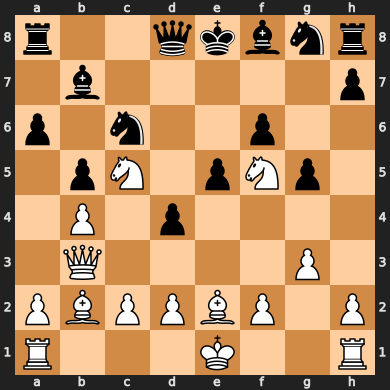

In [24]:
from chess import Board

b = Board("r2qkbnr/1b5p/p1n2p2/1pN1pNp1/1P1p4/1Q4P1/PBPPBP1P/R3K2R")

print(bitboard_to_tensor(b))
b
# move = test(model, b, device)
# encode all moves in the 12 layers?
# print(move)
